<a href="https://colab.research.google.com/github/min20120907/MaskRCNN-w-cell/blob/master/predictive_keyboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 從URL載入、整理訓練資料

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# make English alphabet set
chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', ',', '.', '!']
char_index = dict((c, i) for i, c in enumerate(chars))
index_char = dict((i, c) for i, c in enumerate(chars))
print('char_index:')
print(char_index)
print('index_char:')
print(index_char)

# read training data from url
raw_text = urlopen('https://raw.githubusercontent.com/rushter/MLAlgorithms/master/mla/datasets/data/nietzsche.txt').read().decode('utf-8').lower()

# reserve the English alphabets only
text = []
for ch in raw_text:
    if ch in chars:
        text.append(ch)
    elif ch == '\n':
        text.append(' ')
print('text length:', len(text))

# compose sentences list and next_chars list
SEQUENCE_LENGTH = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print('num training examples: {0}'.format(len(sentences)))

# convert sentences list and next_chars list to training data format
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
Y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_index[char]] = True
    Y[i, char_index[next_chars[i]]] = True

print(sentences[1])
print(next_chars[1])
print(X[1][0])
print(Y[1])
print(X.shape)
print(Y.shape)

char_index:
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, ',': 27, '.': 28, '!': 29}
index_char:
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: ',', 28: '.', 29: '!'}
text length: 590757
num training examples: 196913
['f', 'a', 'c', 'e', ' ', ' ', ' ', 's', 'u', 'p', 'p', 'o', 's', 'i', 'n', 'g', ' ', 't', 'h', 'a']
t
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False  

# 訓練模型、繪製訓練過程的記錄

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               81408     
_________________________________________________________________
dense (Dense)                (None, 30)                3870      
Total params: 85,278
Trainable params: 85,278
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
3742/3742 [==============================] - 32s 9ms/step - loss: 2.2140 - accuracy: 0.3501 - val_loss: 1.9150 - val_accuracy: 0.4317
Epoch 2/5
3742/3742 [==============================] - 32s 9ms/step - loss: 1.8452 - accuracy: 0.4457 - val_loss: 1.7207 - val_accuracy: 0.4816
Epoch 3/5
3742/3742 [==============================] - 32s 9ms/step - loss: 1.6912 - accuracy: 0.4898 - val_loss: 1.6169 - val_accuracy: 0.5130
Epoch 4/5
3742/3742 [==============================] - 33s 9ms/step - loss: 1

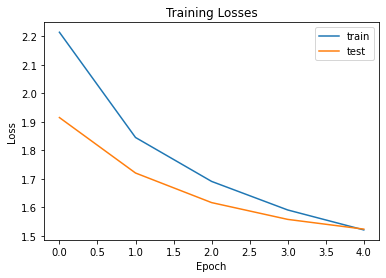

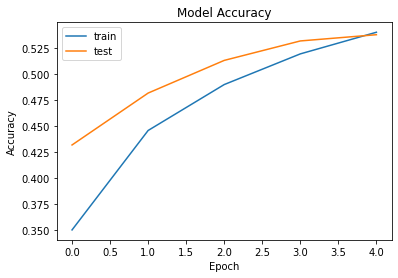

In [0]:
# create the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

# start training
history = model.fit(X, Y, validation_split=0.05, batch_size=50, epochs=5, shuffle=True).history

# draw losses chart
plt.title('Training Losses')
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# draw accuracy chart
plt.title('Model Accuracy')
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 讓模型來預測看看是否有能力補齊單字

In [0]:
import heapq

# convert sentense to match the input format
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
    for i, char in enumerate(text.lower()):
        x[0, SEQUENCE_LENGTH-len(text)+i, char_index[char]] = True
    return x

# get indices of top_n largest values
def nlargest(preds, top_n):
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# complete the prediction of the following words
def predict_completion(text):
    original_text = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = nlargest(preds, top_n=1)[0]
        next_char = index_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if next_char == ' ':
            return completion

# predict n possible following words
def predict_completions(text, n):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = nlargest(preds, n)
    return [index_char[idx] + predict_completion(text[1:] + index_char[idx]) for idx in next_indices]



quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "Im not upset that you lied to me, Im upset that from now on I cant believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!",
    "Im pretty sure that there are many ways to do this, but I fiddled around and came up with a version of my own."
]

for q in quotes:
    seq = q[:20].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of 
['the ', 'something ', 'his ', 'all ', 'man ']

that which does not 
['there ', 'be ', 'destrouse ', 'it ', 'as ']

im not upset that yo
['u ', ' so ', 't ', 'w ', 'r ']

and those who were s
['trange ', 'omething ', 'uch ', 'ympathy ', 'ense ']

it is hard enough to
[' the ', 'o ', 'me ', 'ust ', 're ']

im pretty sure that 
['the ', 'is ', 'a ', 'has ', 'which ']

